In [1]:
from helper_functions import *
import seaborn as sns

# dataset description
* "time" -- records the date and time of production
* "green -- bar was green("1") or not green("0")
* rest are oompa-loompdas names

In [2]:
df = pd.read_csv("../data/Scrumpulicious.csv")
y = df['GREEN']

In [3]:
df.shape

(15806, 62)

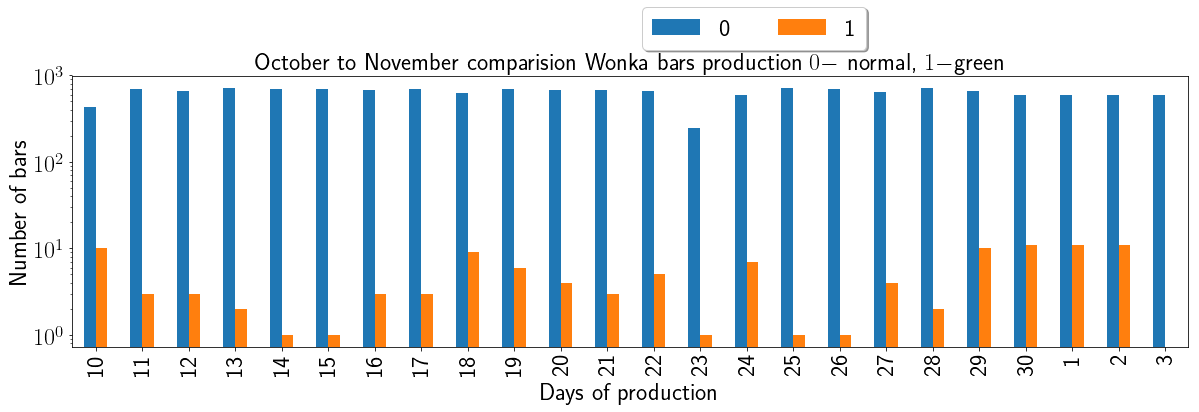

In [4]:
df = data_processing(df)
plot_days(df)
df = df.drop(['TIME','GREEN'], axis=1)

In [5]:
np.unique(y, return_counts=True)

(array([0, 1]), array([15704,   102]))

### Checking for correlation between columns


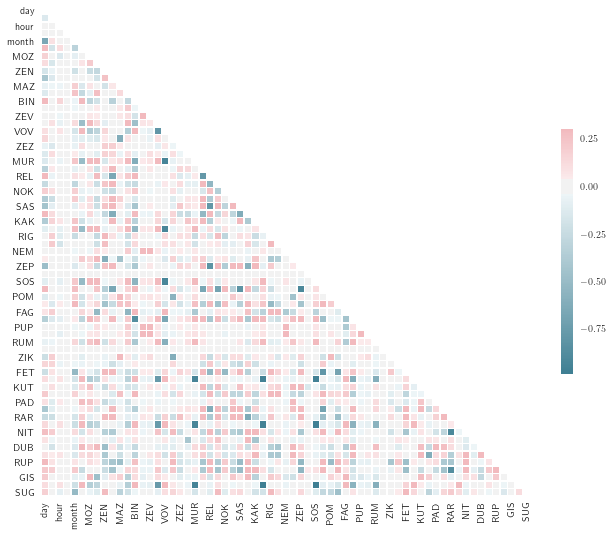

In [6]:
corr_heatmap(df)

### Checking for correlation between columns AFTER getting rid of some columns


before:  (15806, 65)
after:  (15806, 22)
pos: 20	neg: 23


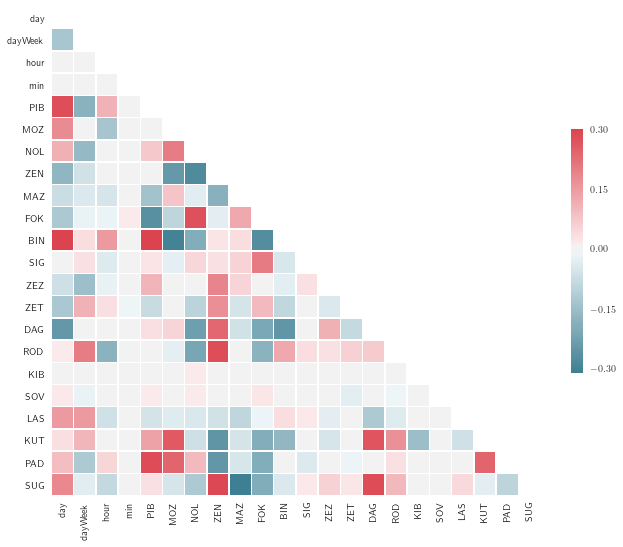

In [7]:
uncorr_df, deleted_columns = correlation(df, 0.32)
X = np.array(uncorr_df)
corr_heatmap(uncorr_df)

# Checking if any columns are from the normal distribution

In [8]:
a = [st.normaltest(X[:,i])[1] for i in range(X.shape[1])]
alpha = 0.05
print((np.array(a)<alpha).all())

True


#### Hence non are from the normal distribution

## Using PCA to preview the data

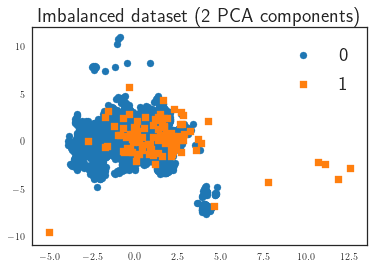

In [9]:
X_pca = standardize_data(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_pca)
plot_2d_space(X_pca, y, 'Imbalanced dataset (2 PCA components)')

------

# Training and building models
   Using SVM and Random Forest classifiers
    1. On an imbalanced dataset 
    2. On a balanced dataset using oversampling techinques

# Imbalanced dataset

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


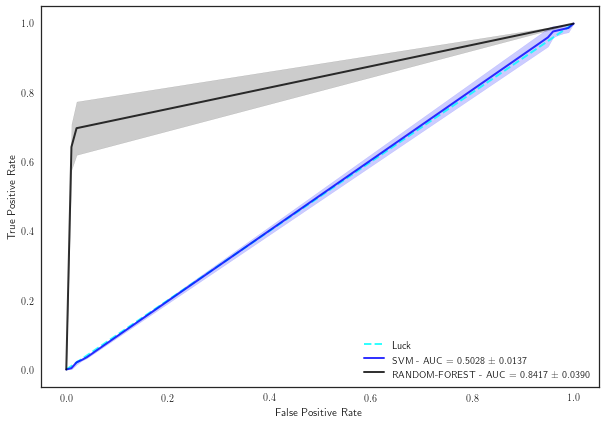

,Model,accuracy,recall,precision,f1-score,param 1,param 2
0,SVM,0.9935468+/-0.0000007,0.0+/-0,0.0+/-0,0.9967629+/-0.0000004,0.001,10
0,RANDOM-FOREST,0.9960+/-0.0006,0.91+/-0.05,0.41+/-0.08,0.9952+/-0.0008,6.000,100


<Figure size 432x288 with 0 Axes>

In [10]:
SVM_1_performance, SVM_1_roc = model(X, y,
                                     n_splits=3, seed=42,
                                     model_name='SVM',
                                    over_sampling = False)
RM_1_performance, RM_1_roc = model(X, y,
                                   n_splits=3, seed=42,
                                   model_name='RANDOM-FOREST',
                                   over_sampling = False)
plot_roc([SVM_1_roc, RM_1_roc])
result = pd.concat([SVM_1_performance, RM_1_performance])
result

The performance is quite poor, let's try to use sampling techniques to better train our model

# balanced (oversampled) dataset
#### dropping SVM as it has really poor results, but on the other hand Random Forst reduces overfitting 
1.  First using cross validation, I will gry to get the best hyperparamters
2. Using the best hyperparamters, I will train a seperate model. This require the right approach to over sampling. Where we have a hold out test set

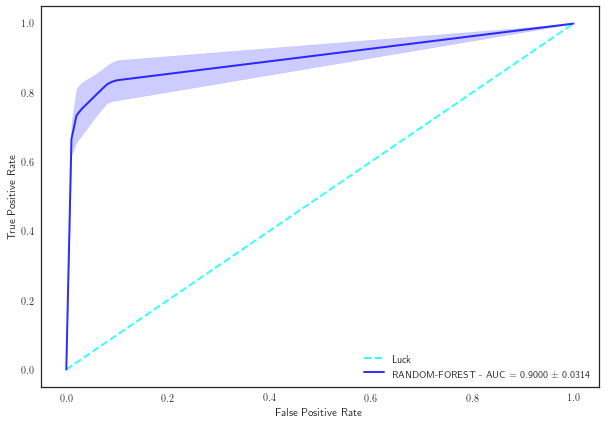

,Model,accuracy,recall,precision,f1-score,param 1,param 2
0,RANDOM-FOREST,0.9947+/-0.0011,0.67+/-0.18,0.402+/-0.017,0.9941+/-0.0009,8,100


<Figure size 432x288 with 0 Axes>

In [11]:
RM_1_performance, RM_1_roc = model(X, y,
                                   n_splits=3, seed=42,
                                   model_name='RANDOM-FOREST',
                                   over_sampling = True)
plot_roc([ RM_1_roc])
RM_1_performance

## Correct way to oversampling knowing the best hyperparameters

In [12]:
X = standardize_data(X)

In [13]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(ratio='minority')

from imblearn.combine import SMOTETomek
smt = SMOTETomek(random_state=42)

In [14]:
# First split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

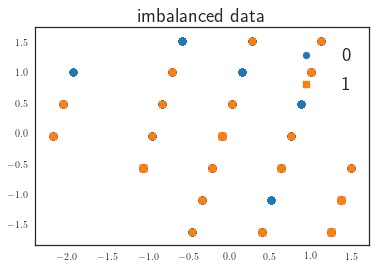

In [15]:
plot_2d_space(X_train, y_train, 'imbalanced data')

In [16]:
# Then split again to oversample only on the training
# not on the validation nore test set

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
#over-sample
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)
print(np.unique(y_train_res, return_counts=True))

(array([0, 1]), array([6591, 6591]))


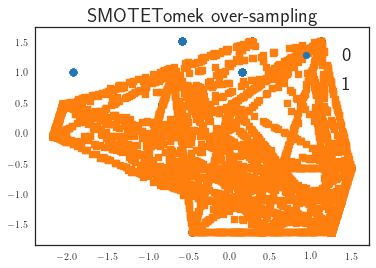

In [17]:
plot_2d_space(x_train_res, y_train_res, 'SMOTETomek over-sampling')

In [42]:
#TRAIN
clf_rf = RandomForestClassifier(n_estimators = 100,
                                max_depth = 6,
                                random_state= 42)
#clf_rf.fit(x_train_res, y_train_res)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [43]:
#X_test, y_test = sm.fit_sample(X_test, y_test)


In [44]:
#metrics
#X_test, y_test = sm.fit_sample(X_test, y_test)
print ('Validation Results')
y_pred_val = clf_rf.predict(X_val)
print ("accuracy: ", clf_rf.score(X_val, y_val))
print ("recll: ",recall_score(y_val, clf_rf.predict(X_val)))
print("classification report:",classification_report(y_val, y_pred_val)) 

print ('\nTest Results')
y_pred_test = clf_rf.predict(X_test)
print ("accuracy: ", clf_rf.score(X_test, y_test))
print ("recll: ", recall_score(y_test, clf_rf.predict(X_test)))
print("classification report:",classification_report(y_test, y_pred_test)) 

Validation Results
accuracy:  0.9971880492091388
recll:  0.5
classification report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2829
           1       1.00      0.50      0.67        16

   micro avg       1.00      1.00      1.00      2845
   macro avg       1.00      0.75      0.83      2845
weighted avg       1.00      1.00      1.00      2845


Test Results
accuracy:  0.9958880278348885
recll:  0.358974358974359
classification report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6284
           1       0.93      0.36      0.52        39

   micro avg       1.00      1.00      1.00      6323
   macro avg       0.96      0.68      0.76      6323
weighted avg       1.00      1.00      0.99      6323



In [38]:
X.shape

(15806, 22)

# saving model

In [21]:
from sklearn.externals import joblib
filename = '../data/finalized_model.sav'
joblib.dump(clf_rf, filename)
 
 

['../data/finalized_model.sav']

In [22]:
# load the model from disk
loaded_model = joblib.load(filename)

In [23]:
test = pd.read_csv("../data/Scrumpulicious_test.csv")
test = data_processing(test)
test = test.drop(deleted_columns, axis=1)
test = test.drop(['TIME','GREEN'], axis=1)
test.head()

,day,dayWeek,hour,min,PIB,MOZ,NOL,ZEN,MAZ,FOK,...,ZEZ,ZET,DAG,ROD,KIB,SOV,LAS,KUT,PAD,SUG
0,6.0,2.0,3.0,0.0,0.32613,4.41527,2.08047,-10.36190,-10.78790,-0.00077,...,0.07340,0.02083,0.86994,-0.02640,0.01400,-2.34362,-0.25956,-0.49867,0.09655,0.00670
1,6.0,2.0,3.0,2.0,0.41189,4.36346,2.04116,-12.45995,-9.79011,-0.00077,...,0.07343,0.02065,0.86994,-0.02318,0.00296,-3.61267,-0.25956,-1.29076,0.09688,0.00671
2,6.0,2.0,3.0,4.0,0.31503,4.49688,2.21122,-10.84578,-9.30919,-0.01129,...,0.07346,0.02048,0.86994,-0.02436,0.05474,-0.46988,-0.25956,-0.59566,0.09721,0.00672
3,6.0,2.0,3.0,6.0,0.26113,4.57136,2.04383,-10.10387,-9.66460,-0.00217,...,0.07348,0.02030,0.86994,-0.04014,0.03564,2.67290,-0.25956,0.77335,0.09754,0.00672
4,6.0,2.0,3.0,8.0,0.22995,4.56271,2.20106,-11.72043,-9.13658,-0.00077,...,0.07351,0.02012,0.86994,-0.03300,0.09948,-1.46339,-0.25956,-0.07228,0.09787,0.00673


In [24]:
test = standardize_data(np.array(test))

In [25]:
y_pred_test = loaded_model.predict(test) 

In [26]:
print("percentage of green bars in training data given")
data = np.unique(y, return_counts=True)[1]
print(("{:.2f}%".format((data[1]/data[0])*100)))

percentage of green bars in training data given
0.65%


In [27]:
print("percentage of green bars in predicted test data given")

data = np.unique(y_pred_test, return_counts=True)[1]
print(("{:.2f}%".format((data[1]/data[0])*100)))

percentage of green bars in predicted test data given
0.27%


In [28]:
y_pred_test = pd.DataFrame(y_pred_test)
y_pred_test.columns = ['GREEN']

In [29]:
y_pred_test.to_csv("Ostyk-Narbutt,Michal_Answers.csv",index=False)

In [30]:
#pd.read_csv("Ostyk-Narbutt,Michal_Answers.csv")

In [31]:
q1 = {"window": 8, "size": 400, "min_count": 5, "alpha": 0.01}

In [32]:
w = dict()

In [33]:
w.update(q1)

In [34]:
q1.update({'score':0.32})

In [35]:
sorted(q1)

['alpha', 'min_count', 'score', 'size', 'window']

In [36]:
X

array([[-1.06515963, -0.5840204 , -0.65104429, ..., -0.02145626,
         0.01264079,  1.6509734 ],
       [-1.06515963, -0.5840204 , -0.65104429, ..., -0.67744007,
         0.01124486,  1.6509734 ],
       [-1.06515963, -0.5840204 , -0.65104429, ..., -0.73664519,
         0.00984893,  1.6509734 ],
       ...,
       [-1.91964438,  0.99717632, -1.22588716, ..., -1.00470019,
         0.02471408, -2.6257528 ],
       [-1.91964438,  0.99717632, -1.22588716, ..., -0.25409506,
         0.02446905, -2.6257528 ],
       [-1.91964438,  0.99717632, -1.22588716, ..., -0.08730554,
         0.02422402, -2.62368974]])